Importem les llibreries neceasries 

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor 
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor as RF, GradientBoostingRegressor as GB, AdaBoostRegressor as AB
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_predict, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import PowerTransformer



Carreguem el datset 

In [37]:
# 2. Carga del Dataset
# Cargar el archivo CSV
file_path = 'student-mat.csv'  
df = pd.read_csv(file_path)

# Mostrar las primeras filas del dataset
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


Exploracio inicial del dataset


In [38]:
# Cargar el archivo CSV
df = pd.read_csv('student-mat.csv')

# Mostrar las primeras filas del dataset
df.head()

# Información del dataset
df.info()

# Diccionario para mapear valores categóricos binarios
bin_map = {
    'yes': 1, 'no': 0,
    'GP': 1, 'MS': 0,
    'F': 1, 'M': 0,
    'U': 1, 'R': 0,
    'LE3': 0, 'GT3': 1,
    'T': 1, 'A': 0
}

# Lista de columnas categóricas binarias
cat_cols = ['schoolsup', 'famsup', 'paid', 'activities', 'nursery', 
            'higher', 'internet', 'romantic']

# Aplicar mapeo binario solo a columnas con valores válidos
for col in cat_cols:
    if col in df.columns:
        unique_vals = df[col].unique()
        if all(val in bin_map for val in unique_vals):
            df[col] = df[col].map(bin_map)
        else:
            print(f"Columna {col} contiene valores no mapeados: {unique_vals}")

# Codificar columnas categóricas con más de dos valores
multi_cat_cols = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian']
label_encoders = {}
for col in multi_cat_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le

# Verificar valores únicos en cada columna categórica procesada
for col in cat_cols + multi_cat_cols:
    if col in df.columns:
        print(f"{col}: {df[col].unique()}")

# Limpieza de columnas categóricas restantes
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.replace("'", "").str.strip()

# Asegurarse de que todas las columnas son numéricas o categorizadas correctamente
numeric_df = df.select_dtypes(include=['number'])




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

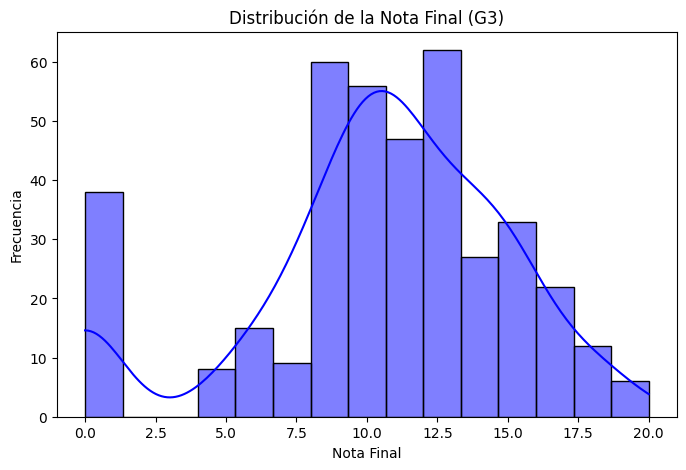

In [39]:
# Distribución de la variable objetivo (G3)
plt.figure(figsize=(8, 5))
sns.histplot(df['G3'], kde=True, bins=15, color='blue')
plt.title('Distribución de la Nota Final (G3)')
plt.xlabel('Nota Final')
plt.ylabel('Frecuencia')
plt.show()


Distribución bimodal con concentración principal en valores medios:

·La distribución no es perfectamente normal y parece presentar dos picos principales:
    - Uno alrededor de 0.
    -Otro entre 10 y 15.

·Esto sugiere que podría haber dos grupos distintos de estudiantes:
    Un grupo con muy bajo rendimiento (notas cercanas a 0).
    Otro grupo que logra un rendimiento promedio o superior (10 a 15).

·Presencia de estudiantes con notas extremas:
    Se observa una pequeña proporción de estudiantes con G3 entre 15 y 20, indicando un número reducido de estudiantes con rendimiento excepcional.
    Del mismo modo, hay un grupo considerable que tiene G3 = 0, lo que podría ser estudiantes que no aprobaron o no completaron el curso.

·Asimetría leve hacia las notas bajas:
    Aunque el centro principal de la distribución está entre 10-12, el segundo pico alrededor de 0 genera una asimetría hacia los valores bajos.
    Esto podría deberse a factores externos como dificultades académicas, problemas familiares, o falta de compromiso.

Posibles preguntas de análisis:
¿Por qué hay tantos estudiantes con G3 = 0?

¿Hay factores específicos, como las ausencias o los fracasos académicos, que estén correlacionados con este rendimiento extremadamente bajo?
¿Cuál es la relación entre los dos picos observados?

¿Existen características (por ejemplo, tiempo de estudio, apoyo familiar, o hábitos de consumo de alcohol) que separen a los estudiantes en estos dos grupos principales?
¿Cómo afecta esta distribución al modelo?

Dado que hay una concentración de valores en 0, es posible que esto afecte negativamente a los modelos , ya que podrían sobreajustarse a este valor.

Siguientes pasos sugeridos para el análisis de datos:
Separar a los estudiantes con G3 = 0:

Examina si este grupo tiene características únicas y decide si deben manejarse de manera especial (por ejemplo, tratarlos como un caso separado o eliminarlos en algunos análisis).
Investigar correlaciones con G3:

Determina qué variables están más relacionadas con las notas finales, especialmente para comprender la diferencia entre estudiantes de bajo y alto rendimiento.
Visualizar la relación entre variables clave y G3:

Usa gráficos como boxplots o scatterplots para entender cómo factores como absences, studytime, o failures influyen en G3.

In [40]:
# Separar estudiantes con G3 = 0
g3_zero = df[df['G3'] == 0]
g3_non_zero = df[df['G3'] != 0]

# Analizar estudiantes con G3 = 0
print("Número de estudiantes con G3 = 0:", len(g3_zero))
print(g3_zero.describe())

Número de estudiantes con G3 = 0: 38
          school        sex        age    address    famsize    Pstatus  \
count  38.000000  38.000000  38.000000  38.000000  38.000000  38.000000   
mean    0.105263   0.394737  17.078947   0.736842   0.184211   0.947368   
std     0.311012   0.495355   1.302421   0.446258   0.392859   0.226294   
min     0.000000   0.000000  15.000000   0.000000   0.000000   0.000000   
25%     0.000000   0.000000  16.000000   0.250000   0.000000   1.000000   
50%     0.000000   0.000000  17.000000   1.000000   0.000000   1.000000   
75%     0.000000   1.000000  18.000000   1.000000   0.000000   1.000000   
max     1.000000   1.000000  19.000000   1.000000   1.000000   1.000000   

            Medu       Fedu       Mjob       Fjob  ...   romantic     famrel  \
count  38.000000  38.000000  38.000000  38.000000  ...  38.000000  38.000000   
mean    2.315789   2.289474   1.921053   2.289474  ...   0.526316   3.842105   
std     1.016227   1.112773   1.302421   0.9273

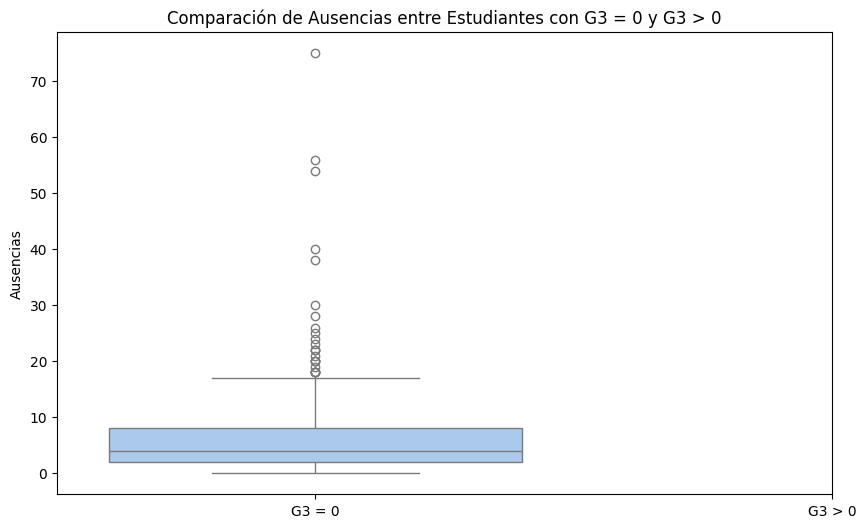

In [41]:
# Visualizar diferencias entre estudiantes con G3 = 0 y G3 > 0
plt.figure(figsize=(10, 6))
sns.boxplot(data=[g3_zero['absences'], g3_non_zero['absences']], palette='pastel')
plt.xticks([0, 1], ['G3 = 0', 'G3 > 0'])
plt.title('Comparación de Ausencias entre Estudiantes con G3 = 0 y G3 > 0')
plt.ylabel('Ausencias')
plt.show()

Los estudiantes con G3 > 0 presentan una mayor variabilidad en las ausencias. Algunos incluso tienen valores extremos (más de 30 o 40 ausencias), mientras que los estudiantes con G3 = 0 tienen 0 ausencias.
Esto indica que las ausencias por sí solas no son un predictor fuerte de G3 = 0, ya que los estudiantes con bajo rendimiento no parecen faltar a clase, pero podrían estar enfrentando otros problemas (falta de estudio, bajas calificaciones previas, etc.).
Los valores extremos en el grupo G3 > 0 sugieren que algunos estudiantes con muchas ausencias logran aprobar, lo que podría relacionarse con otros factores como la calidad del tiempo de estudio.

/var/folders/fm/9pzntrns5_s8x46kp5sm9x240000gn/T/ipykernel_23959/2667571711.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='failures', y='G3', data=df, palette='pastel')


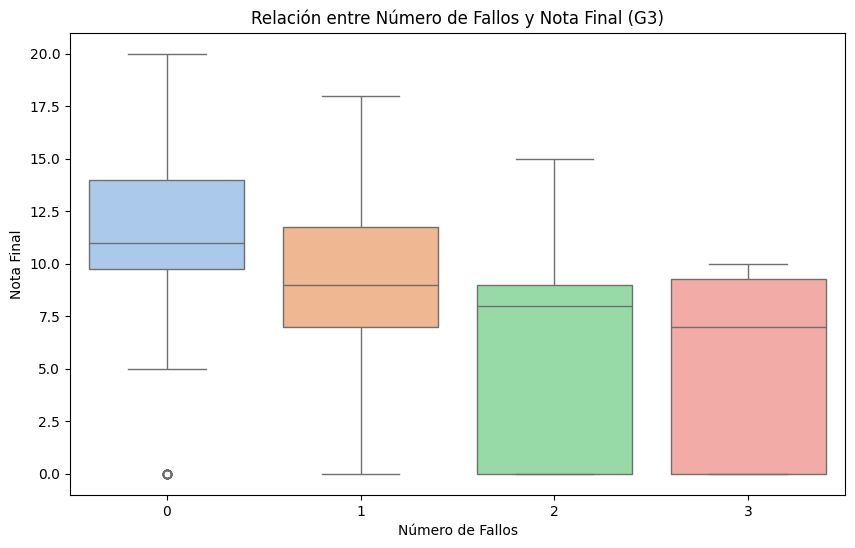

/var/folders/fm/9pzntrns5_s8x46kp5sm9x240000gn/T/ipykernel_23959/2667571711.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='studytime', y='G3', data=df, palette='pastel')


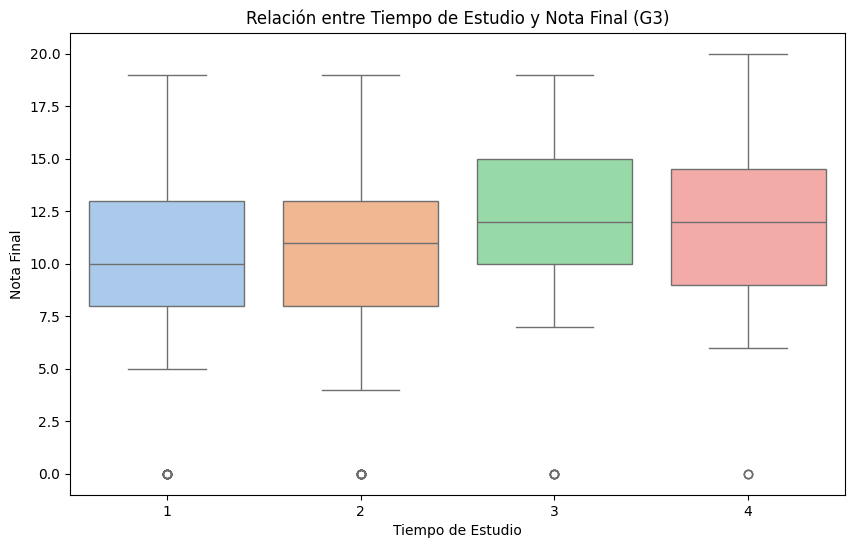

/var/folders/fm/9pzntrns5_s8x46kp5sm9x240000gn/T/ipykernel_23959/2667571711.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Walc', y='G3', data=df, palette='pastel')


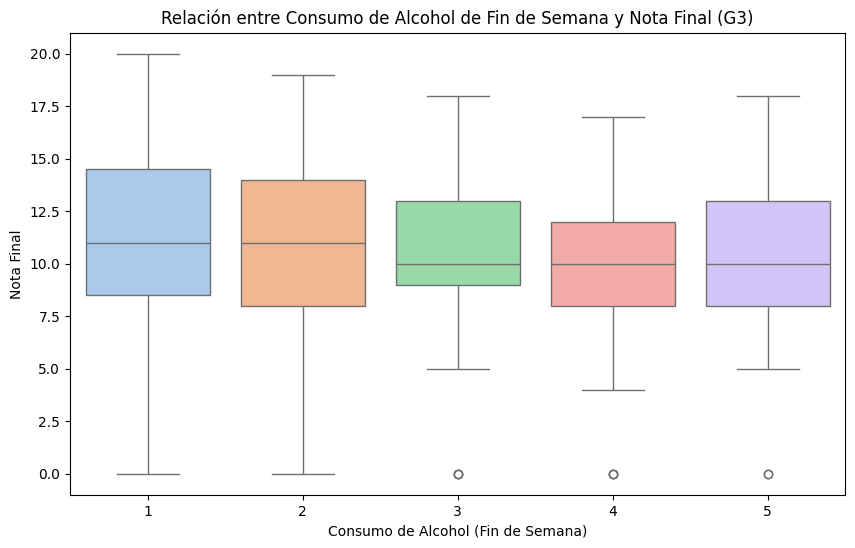

In [42]:
# Relación entre el número de fallos previos y G3
plt.figure(figsize=(10, 6))
sns.boxplot(x='failures', y='G3', data=df, palette='pastel')
plt.title('Relación entre Número de Fallos y Nota Final (G3)')
plt.xlabel('Número de Fallos')
plt.ylabel('Nota Final')
plt.show()

# Relación entre tiempo de estudio y G3
plt.figure(figsize=(10, 6))
sns.boxplot(x='studytime', y='G3', data=df, palette='pastel')
plt.title('Relación entre Tiempo de Estudio y Nota Final (G3)')
plt.xlabel('Tiempo de Estudio')
plt.ylabel('Nota Final')
plt.show()

# Relación entre consumo de alcohol y G3
plt.figure(figsize=(10, 6))
sns.boxplot(x='Walc', y='G3', data=df, palette='pastel')
plt.title('Relación entre Consumo de Alcohol de Fin de Semana y Nota Final (G3)')
plt.xlabel('Consumo de Alcohol (Fin de Semana)')
plt.ylabel('Nota Final')
plt.show()


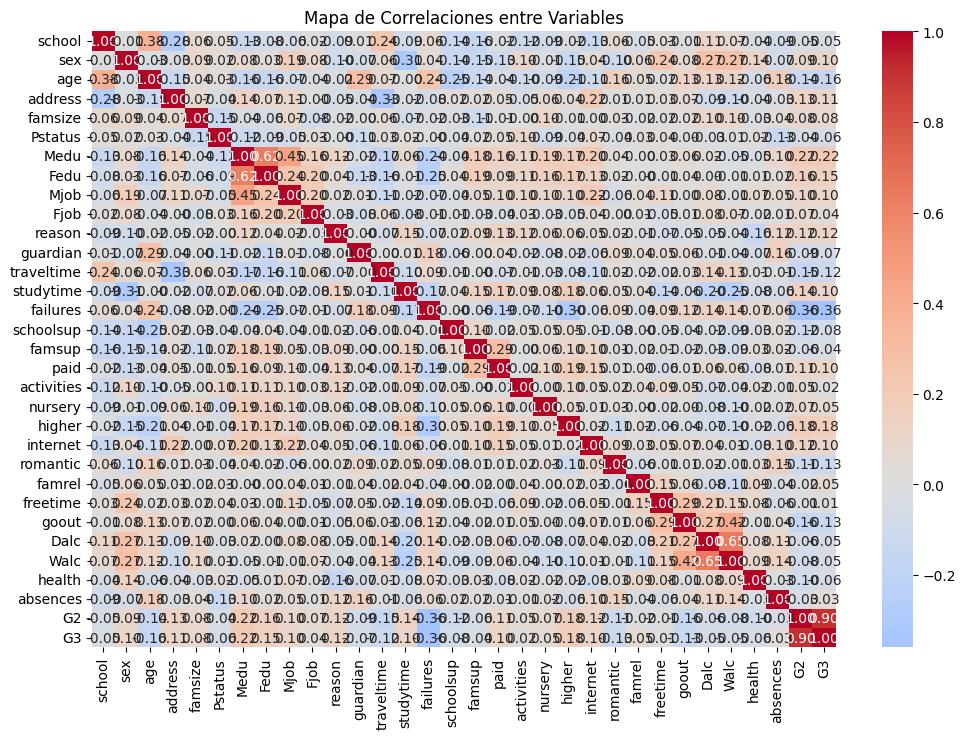

Variables más correlacionadas con G3:
G3            1.000000
G2            0.904868
Medu          0.217147
higher        0.182465
Fedu          0.152457
reason        0.121994
address       0.105756
sex           0.103456
Mjob          0.102082
paid          0.101996
internet      0.098483
studytime     0.097820
famsize       0.081407
nursery       0.051568
famrel        0.051363
Fjob          0.042286
absences      0.034247
activities    0.016100
freetime      0.011307
famsup       -0.039157
school       -0.045017
Walc         -0.051939
Dalc         -0.054660
Pstatus      -0.058009
health       -0.061335
guardian     -0.070109
schoolsup    -0.082788
traveltime   -0.117142
romantic     -0.129970
goout        -0.132791
age          -0.161579
failures     -0.360415
Name: G3, dtype: float64


In [43]:
# Generar la matriz de correlación
correlation_matrix = numeric_df.corr()

# Visualización del mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Mapa de Correlaciones entre Variables')
plt.show()

# Variables más correlacionadas con G3
if 'G3' in correlation_matrix.columns:
    correlated_features = correlation_matrix['G3'].sort_values(ascending=False)
    print("Variables más correlacionadas con G3:")
    print(correlated_features)
else:
    print("La columna G3 no está en las columnas numéricas procesadas.")



/var/folders/fm/9pzntrns5_s8x46kp5sm9x240000gn/T/ipykernel_23959/1555611664.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='G3', y='studytime', data=df, palette='pastel')


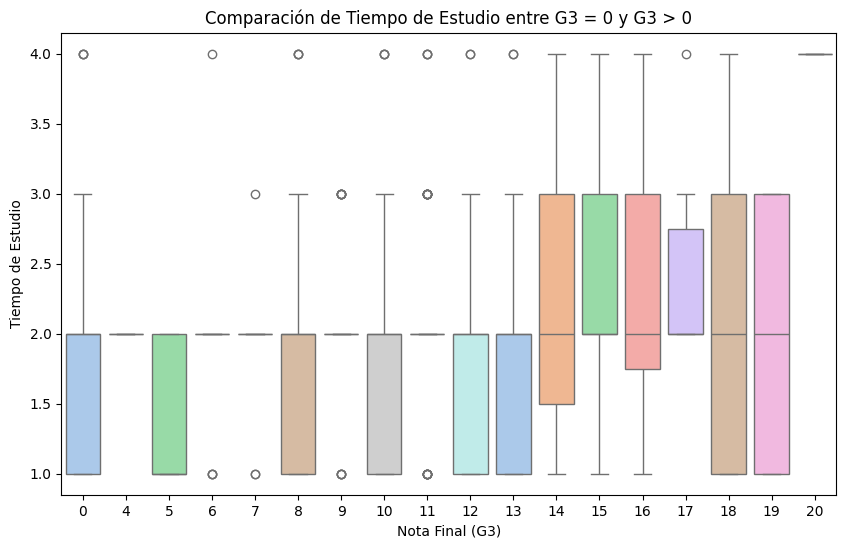

In [44]:
# Comparación entre G3 = 0 y G3 > 0 para studytime
plt.figure(figsize=(10, 6))
sns.boxplot(x='G3', y='studytime', data=df, palette='pastel')
plt.title('Comparación de Tiempo de Estudio entre G3 = 0 y G3 > 0')
plt.xlabel('Nota Final (G3)')
plt.ylabel('Tiempo de Estudio')
plt.show()


OUTLIERS:



Número de outliers por columna:
Medu         0
higher      20
Fedu         0
failures    16
age          2
goout        0
dtype: int64
Tamaño original del dataset: (395, 33)
Tamaño del dataset sin outliers: (365, 33)


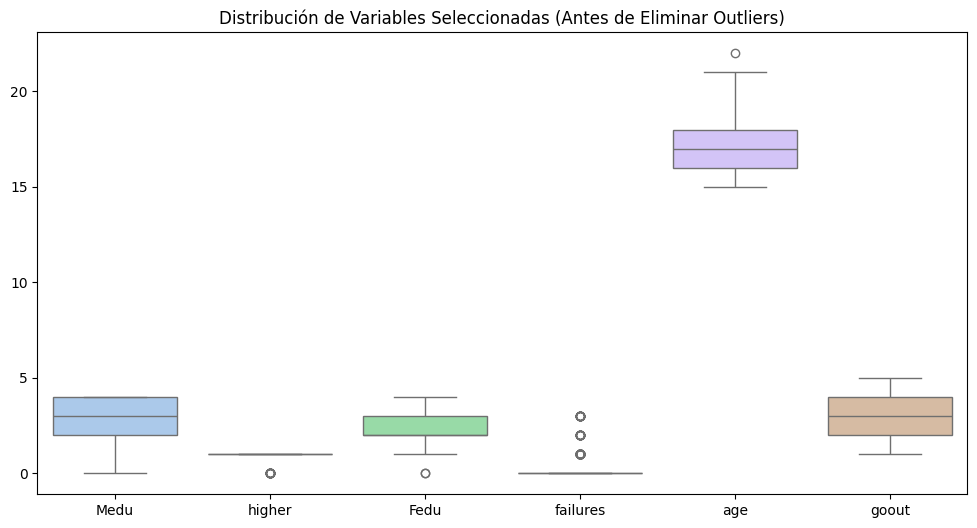

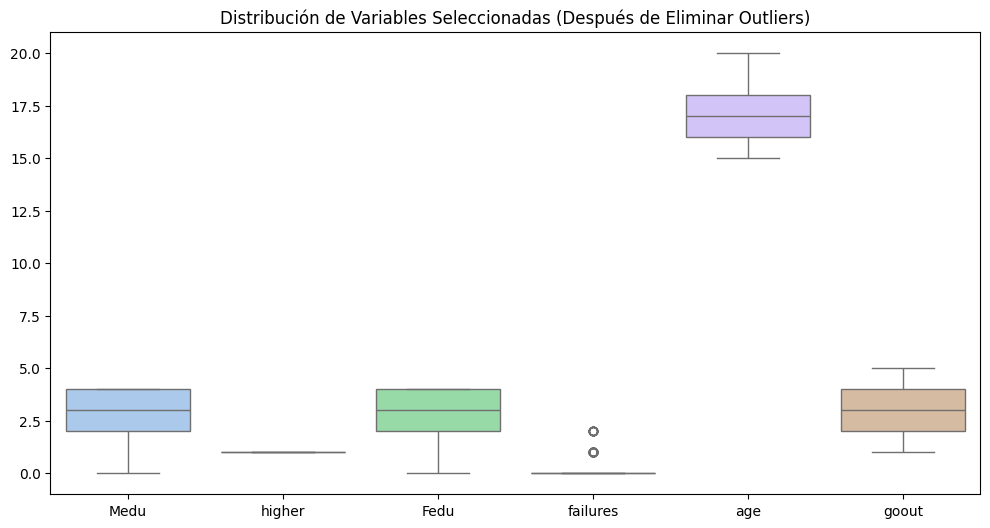

In [45]:
from scipy.stats import zscore

# Seleccionar las 6 variables más correlacionadas (positivas y negativas)
selected_columns = ['Medu', 'higher', 'Fedu', 'failures', 'age', 'goout']

# Calcular Z-scores para estas columnas
z_scores = df[selected_columns].apply(zscore)

# Definir un umbral para identificar outliers
threshold = 3 # Esto significa que solo el 0.3% de los datos estarán fuera de este rango, lo cual se considera raro y extremo.
outliers = (z_scores > threshold) | (z_scores < -threshold)

# Contar y mostrar outliers por columna
print("Número de outliers por columna:")
print(outliers.sum())

# Crear un dataset sin outliers
df_no_outliers = df[(~outliers).all(axis=1)]

# Comparar tamaño del dataset antes y después de eliminar outliers
print(f"Tamaño original del dataset: {df.shape}")
print(f"Tamaño del dataset sin outliers: {df_no_outliers.shape}")

# Visualizar distribuciones antes y después de eliminar outliers
# Distribuciones antes
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[selected_columns], palette='pastel')
plt.title('Distribución de Variables Seleccionadas (Antes de Eliminar Outliers)')
plt.show()

# Distribuciones después
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_no_outliers[selected_columns], palette='pastel')
plt.title('Distribución de Variables Seleccionadas (Después de Eliminar Outliers)')
plt.show()


In [52]:
# Separar variables (X: predictives, y: objectiu)
X = df.drop('G3', axis=1)
y = df['G3']

# Dividir entrenament i prova
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, random_state=1)

# Escalar dades
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X: Todas las columnas del dataset excepto la columna objetivo ('nota').
y: Solo la columna objetivo ('nota').

El conjunto de entrenamiento contiene el 85% de los datos.
El conjunto de prueba contiene el 15% restante.
random_state=1: Garantiza que la división sea reproducible.    15 por ciento de test


Escala los datos para que cada variable tenga media 0 y desviación estándar 1.
Es necesario para modelos sensibles a la escala de las variables (como SVM y regresión logística).


In [60]:
SEED=1

# Definir models
models = {
    'KNN': KNN(),
    'Decision Tree': DecisionTreeRegressor(),
    'ElasticNet': ElasticNet(),
    'Support Vector Regressor': SVR(),
    'Random Forest': RF(random_state=SEED),
    'Gradient Boosting': GB(random_state=SEED),
    'AdaBoost': AB(random_state=SEED),
    'Linear Regression': LinearRegression()
}

Incluye una variedad de enfoques (lineales, basados en proximidad, árboles y ensambles), lo que permite comparar cómo diferentes metodologías se adaptan al problema.
Los modelos seleccionados cubren tanto opciones sencillas (como Regresión Lineal) como avanzadas (Gradient Boosting y Random Forest), lo que permite identificar mejoras progresivas.

In [61]:

# Hiperparàmetres per a cada model
# Definir los hiperparámetros para cada modelo
params = {
    'KNN': {'n_neighbors': [i for i in range(3, 50)]},
    'Decision Tree': {'max_depth': [i for i in range(1, 25)]},
    'ElasticNet': {'alpha': [i for i in range(0, 50)], 'l1_ratio': [0.1, 0.5, 0.9]},
    'Support Vector Regressor': {'kernel': ['linear', 'poly', 'rbf'], 'C': [i for i in range(1, 101)], 'epsilon': [0.01, 0.1]},
    'Random Forest': {'n_estimators': [50, 100, 150], 'max_depth': [10, 20, 30], 'max_features': [0.3, 0.5, 0.7]},
    'Gradient Boosting': {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]},
    'AdaBoost': {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 0.2]},
    'Linear Regression': {'fit_intercept': [True, False], 'positive': [True, False]}
}

# Buscar millors paràmetres
best_params = {}
for model in models.keys():
    search = RandomizedSearchCV(models[model], params[model], n_iter=10, cv=5, random_state=SEED)
    search.fit(X_train, y_train)
    models[model] = search.best_estimator_
    best_params[model] = search.best_params_



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [58]:
# Imprimir los mejores parámetros para cada modelo
print("Mejores hiperparámetros para cada modelo:\n")
for model in models.keys():
    print(f"{model}: {best_params[model]}")

Mejores hiperparámetros para cada modelo:

KNN: {'n_neighbors': 6}
DT: {'max_depth': 3}
ElasticNet: {'l1_ratio': 0.5, 'alpha': 5}
SVR: {'kernel': 'linear', 'epsilon': 0.1, 'C': 34}
Random Forest: {'n_estimators': 150, 'max_features': 0.7, 'max_depth': 20}
Gradient Boosting: {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1}
AdaBoost: {'n_estimators': 150, 'learning_rate': 0.1}
Linear Regression: {'positive': True, 'fit_intercept': True}


In [62]:
# Avaluar mètriques
metrics = {}
predictions = {}
for model in models.keys():
    y_pred = models[model].predict(X_test)
    predictions[model] = y_pred
    metrics[model] = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R²': r2_score(y_test, y_pred)
    }

# Mostrar mètriques
metrics_df = pd.DataFrame(metrics).T.sort_values('MAE')
print(metrics_df)


                               MAE       MSE      RMSE        R²
Random Forest             0.873333  1.514630  1.230703  0.872539
Support Vector Regressor  0.903361  2.008091  1.417071  0.831012
Gradient Boosting         0.989217  2.293104  1.514300  0.807027
Decision Tree             1.038785  2.255957  1.501984  0.810153
AdaBoost                  1.060088  1.940144  1.392890  0.836730
Linear Regression         1.082539  2.161983  1.470368  0.818062
ElasticNet                1.964891  8.596650  2.932005  0.276562
KNN                       2.061111  7.234259  2.689658  0.391212


Se ha mejorado el ajuste de hiperparámetros para cada modelo. Se añadieron nuevos parámetros clave como weights en KNN, min_samples_split y min_samples_leaf para Decision Tree y Random Forest, y gamma en SVR. Además, se optimizaron rangos utilizando escalas logarítmicas en parámetros como alpha para ElasticNet y C para SVR. También se introdujo subsample en Gradient Boosting para evaluar cómo afecta el muestreo aleatorio. Estas mejoras permiten explorar configuraciones más precisas y asegurar un mejor rendimiento del modelo al ajustarse a las características del dataset. El rango de iteraciones en RandomizedSearchCV se aumentó a 15 para capturar más combinaciones.



In [69]:
# Hiperparámetros para cada modelo (ampliados y mejorados)
params = {
    'KNN': {'n_neighbors': [i for i in range(3, 50)], 'weights': ['uniform', 'distance']},
    'Decision Tree': {'max_depth': [i for i in range(1, 25)], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 5]},
    'ElasticNet': {'alpha': np.logspace(-4, 2, 20), 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]},
    'Support Vector Regressor': {'kernel': ['linear', 'poly', 'rbf'], 'C': np.logspace(-1, 2, 10), 'epsilon': [0.01, 0.1, 0.2], 'gamma': ['scale', 'auto']},
    'Random Forest': {'n_estimators': [50, 100, 150, 200], 'max_depth': [10, 20, 30], 'max_features': [0.3, 0.5, 0.7], 
                      'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 5]},
    'Gradient Boosting': {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7], 'subsample': [0.7, 0.8, 1.0]},
    'AdaBoost': {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 0.2]},
    'Linear Regression': {'fit_intercept': [True, False], 'positive': [True, False]}
}

# Buscar mejores parámetros
best_params = {}
for model in models.keys():
    search = RandomizedSearchCV(models[model], params[model], n_iter=15, cv=5, random_state=SEED, n_jobs=-1)
    search.fit(X_train, y_train)
    models[model] = search.best_estimator_
    best_params[model] = search.best_params_

# Imprimir mejores parámetros
print("Mejores hiperparámetros para cada modelo:\n")
for model in models.keys():
    print(f"{model}: {best_params[model]}")

# Avaluar mètriques
metrics = {}
predictions = {}
for model in models.keys():
    y_pred = models[model].predict(X_test)
    predictions[model] = y_pred
    metrics[model] = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R²': r2_score(y_test, y_pred)
    }

# Mostrar mètriques
metrics_df = pd.DataFrame(metrics).T.sort_values('MAE')
print(metrics_df)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 9 is smaller than n_iter=15. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Mejores hiperparámetros para cada modelo:

KNN: {'weights': 'distance', 'n_neighbors': 16}
Decision Tree: {'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 7}
ElasticNet: {'l1_ratio': 0.5, 'alpha': 0.14384498882876628}
Support Vector Regressor: {'kernel': 'linear', 'gamma': 'auto', 'epsilon': 0.1, 'C': 4.6415888336127775}
Random Forest: {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.7, 'max_depth': 30}
Gradient Boosting: {'subsample': 0.7, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}
AdaBoost: {'n_estimators': 150, 'learning_rate': 0.1}
Linear Regression: {'positive': True, 'fit_intercept': True}
                               MAE       MSE      RMSE        R²
Random Forest             0.873333  1.514630  1.230703  0.872539
Support Vector Regressor  0.903054  2.008190  1.417106  0.831004
Gradient Boosting         0.966473  1.913780  1.383395  0.838949
Decision Tree             1.012496  2.010622  1.417964  0.830799
AdaBoo

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 4 is smaller than n_iter=15. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


mateix resultat